# Homework 2

In [1]:
from warnings import filterwarnings
filterwarnings('ignore')

## Question 1

#### Download and parse the 5year.arff file.

In [2]:
f = open("data/5year.arff", 'r')
    
while not '@data' in f.readline():
    pass

dataset = []
for l in f:
    if '?' in l: # Missing entry
        continue
    l = l.split(',')
    values = [1] + [float(x) for x in l]
    values[-1] = values[-1] > 0 # Convert to bool
    dataset.append(values)

#### Train a logistic regressor with regularization coefficient C = 1.0. Report the accuracy and Balanced Error Rate (BER) of your classifier.

In [3]:
X = [values[:-1] for values in dataset]
y = [values[-1] for values in dataset]
from sklearn import linear_model
model = linear_model.LogisticRegression(C = 1)
model.fit(X,y)

predictions = model.predict(X)

# accuracy
correctPredictions = predictions == y
accuracy = sum(correctPredictions) / len(correctPredictions)
print("Accuracy = " + str(accuracy))

# BER
def BER(p, t):
    TP=sum([(a and b) for (a,b) in zip(p, t)])
    FP=sum([(a and not b) for (a,b) in zip(p, t)])
    TN=sum([(not a and not b) for (a,b) in zip(p, t)])
    FN=sum([(not a and b) for (a,b) in zip(p, t)])
    TPR = TP / (TP + FN)
    TNR = TN / (TN + FP)
    BalancedErrorRate = 1 - 1/2 * (TPR + TNR)
    return(BalancedErrorRate)

print("Balanced error rate = " + str(BER(predictions, y)))

Accuracy = 0.9666776641372484
Balanced error rate = 0.48090427704028005


## Question 3

#### Shuffle the data, and split it into training, validation, and test splits, with a 50/25/25% ratio.

In [4]:
import random
random.seed(1996)
random.shuffle(dataset)

X = [values[:-1] for values in dataset]
y = [values[-1] for values in dataset]

N = len(X)
X_train = X[:N//2]
X_valid = X[N//2:3*N//4]
X_test = X[3*N//4:]
y_train = y[:N//2]
y_valid = y[N//2:3*N//4]
y_test = y[3*N//4:]

#### Using the class weight=’balanced’ option, and training on the training set, report the training/validation/test accuracy and BER.

In [5]:
train_a = []
valid_a = []
test_a = []
train_BER = []
valid_BER = []
test_BER = []

def model(n):

    model = linear_model.LogisticRegression(C=n, class_weight='balanced')
    model.fit(X_train,y_train)
    
    train_predictions = model.predict(X_train)
    valid_predictions = model.predict(X_valid)
    test_predictions = model.predict(X_test)
    train_correct = train_predictions == y_train
    valid_correct = valid_predictions == y_valid
    test_correct = test_predictions == y_test

    train_accuracy = sum(train_correct) / len(train_correct)
    valid_accuracy = sum(valid_correct) / len(valid_correct)
    test_accuracy = sum(test_correct) / len(test_correct)
    
    train_a.append(train_accuracy)
    valid_a.append(valid_accuracy)
    test_a.append(test_accuracy)
    train_BER.append(BER(train_predictions, y_train))
    valid_BER.append(BER(valid_predictions, y_valid))
    test_BER.append(BER(test_predictions, y_test))
    
model(1)
print("Train accuracy = " + str(train_a[0]), "   Train BER = " + str(train_BER[0]))
print("Valid accuracy = " + str(valid_a[0]), "   Valid BER = " + str(valid_BER[0]))
print("Test accuracy = " + str(test_a[0]), "   Test BER = " + str(test_BER[0]))

Train accuracy = 0.7273927392739274    Train BER = 0.2594404150427174
Valid accuracy = 0.7150395778364116    Valid BER = 0.2390644181688958
Test accuracy = 0.741424802110818    Test BER = 0.23727984344422703


## Question 4

#### Implement a complete regularization pipeline with the balanced classifier. Consider values of C in the range {10−4,10−3,...,103,104}. Report (or plot) the train, validation, and test BER for each value of C.

In [6]:
power=range(-4,5)
c=[]
train_a = []
valid_a = []
test_a = []
train_BER = []
valid_BER = []
test_BER = []

for n in power:
    model(10**n)
    c.append(n)
    
import pandas as pd
import matplotlib.pyplot as plt 

df = pd.DataFrame(list(zip(c, train_BER, valid_BER, test_BER)),
 columns =['C=10**n', 'train BER', 'validation BER', 'test BER'])
df

,C=10**n,train BER,validation BER,test BER
0,-4,0.267790,0.250598,0.235176
1,-3,0.292814,0.257382,0.241341
2,-2,0.285632,0.247206,0.228327
3,-1,0.289052,0.251276,0.236546
4,0,0.259440,0.239064,0.237280
5,1,0.246928,0.233637,0.237280
6,2,0.188873,0.212606,0.225685
7,3,0.270242,0.235672,0.217368
8,4,0.279476,0.247206,0.229697


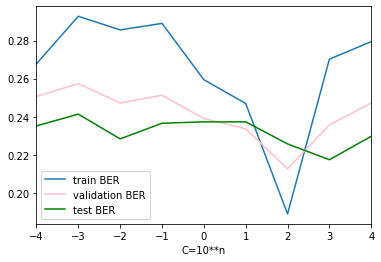

In [7]:
ax = plt.gca()
df.plot(kind='line',x='C=10**n',y='train BER', ax=ax)
df.plot(kind='line',x='C=10**n',y='validation BER', color='pink', ax=ax)
df.plot(kind='line',x='C=10**n',y='test BER', color='green', ax=ax)
plt.show()

#### Based on these values, which classifier would you select (in terms of generalization performance) and why?

In [8]:
print('I will choose the classifier with C equals 10 to the power of ' +
      str(int(df[df['validation BER']==min(df['validation BER'])]['C=10**n'])) +
      ', because it has the lowest BER on the validation set.')

I will choose the classifier with C equals 10 to the power of 2, because it has the lowest BER on the validation set.


## Question 6

#### Assigning larger weights to (e.g.) positive samples would encourage the logistic regressor to optimize for the True Positive Rate. Using the above code, compute the Fβ score (on the test set) of your (unweighted) classifier, for β = 1 and β = 10.  

In [9]:
weights = [1.0] * len(y_train)
F1s = []
F10s = []
def model_weight(weights):
    mod = linear_model.LogisticRegression(C=1, solver='lbfgs')
    mod.fit(X_train, y_train, sample_weight=weights)
    train_predictions = mod.predict(X_train)
    test_predictions = mod.predict(X_test)
    train_correct = train_predictions == y_train
    test_correct = test_predictions == y_test
    
    TP=sum([(a and b) for (a,b) in zip(test_predictions, y_test)])
    FP=sum([(a and not b) for (a,b) in zip(test_predictions, y_test)])
    TN=sum([(not a and not b) for (a,b) in zip(test_predictions, y_test)])
    FN=sum([(not a and b) for (a,b) in zip(test_predictions, y_test)])
    precision = TP / (TP + FP)
    recall = TP / (TP + FN)
    β = 1
    F1 = (1 + β**2)*precision*recall/(β**2*precision+recall)
    F1s.append(F1)
    β = 10
    F10 = (1 + β**2)*precision*recall/(β**2*precision+recall)
    F10s.append(F10)
    
model_weight(weights)
print('F1 =' + str(F1s[0]))
print('F10 =' + str(F10s[0]))

F1 =0.125
F10 =0.07203994293865905


#### Following this, identify weight vectors that yield better performance (compared to the unweighted vector) in terms of the F1 and F10 scores

In [10]:
# including the unweighted vector as 1
weightvector=[]
F1s = []
F10s = []
for w in range(1,50):
    weights =[]
    weightvector.append(w)
    for i in range(len(y_train)):
        if y_train[i] == True:
            weights.append(w)
        else:
            weights.append(1)
    model_weight(weights)
    
df = pd.DataFrame(list(zip(weightvector, F1s, F10s)), columns =['weight vector', 'F1', 'F10'])
df.head(10)

,weight vector,F1,F10
0,1,0.125000,0.072040
1,2,NaN,NaN
2,3,0.222222,0.143875
3,4,0.222222,0.143875
4,5,0.222222,0.143875
5,6,0.216216,0.143823
6,7,0.205128,0.143721
7,8,0.166667,0.143262
8,9,0.153846,0.143059
9,10,0.153846,0.143059


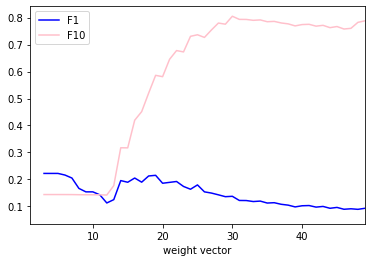

In [11]:
ax = plt.gca()
df.plot(kind='line',x='weight vector',y='F1', color='blue', ax=ax)
df.plot(kind='line',x='weight vector',y='F10', color='pink', ax=ax)
plt.show()

In [12]:
print('In terms of F1 I will choose any weight vector among ' +
      str(df[df['F1']==max(df['F1'])]['weight vector'].values.tolist()) +
      ', because they have the highest scores compared to the unweighted vector.')

print('In terms of F10 I will choose weight vector of ' +
      str(int(df[df['F10']==max(df['F10'])]['weight vector'])) +
      ', because it has the highest score compared to the unweighted vector.')

In terms of F1 I will choose any weight vector among [3, 4, 5], because they have the highest scores compared to the unweighted vector.
In terms of F10 I will choose weight vector of 30, because it has the highest score compared to the unweighted vector.


## Question 7

#### Following the stub code, compute the PCA basis on the training set. Report the first PCA component (i.e., pca.components [0]) 

In [13]:
from sklearn.decomposition import PCA
pca = PCA()
pca.fit(X_train)
print(pca.components_[0])

[-4.55811241e-19  4.01127811e-08  1.76042485e-07  1.45960669e-06
  6.33467868e-06  3.20557945e-03 -7.06732054e-07  1.94634213e-06
  6.47000975e-06 -9.86560943e-07  3.09672890e-08  3.57189835e-07
  1.63725408e-06 -6.57758514e-06  1.94589865e-06 -5.73264411e-03
  1.49178059e-06  7.25992395e-06  1.78290014e-06  3.82533477e-07
  6.14356085e-05 -1.54660418e-05  2.80898732e-07  3.24422266e-07
  9.13111605e-07  9.15195672e-07  1.33860631e-06 -5.63070288e-05
  4.24597614e-05  4.12080691e-06 -1.61872404e-06  3.73154983e-07
 -8.11596788e-04  4.91204455e-06 -1.89050851e-06  2.65155464e-07
 -9.31764129e-07  8.04281055e-03 -5.18865577e-07  2.15638026e-07
  2.91536795e-06 -1.25495559e-06  1.23500250e-07  1.16310756e-04
  5.48720317e-05 -3.34153304e-07  4.69295093e-06 -4.67608745e-04
  3.20997749e-07  2.65641432e-07  5.76673194e-06 -9.76217673e-07
 -2.20474062e-06 -4.84867270e-06  4.23946159e-05  9.99945575e-01
  2.21896631e-07  1.19042824e-06 -2.84304704e-07 -2.08165424e-06
 -1.22927206e-04 -8.82690

## Question 8

#### Next we’ll train a model using a low-dimensional feature vector. By representing the data in the above basis, i.e.:
#### Xpca_train = numpy.matmul(Xtrain, pca.components_.T)
#### Xpca_valid = numpy.matmul(Xvalid, pca.components_.T)
#### Xpca_test = numpy.matmul(Xtest, pca.components_.T)

In [14]:
import numpy
Xpca_train = numpy.matmul(X_train, pca.components_.T)
Xpca_valid = numpy.matmul(X_valid, pca.components_.T)
Xpca_test = numpy.matmul(X_test, pca.components_.T)

#### compute the validation and test BER of a model that uses just the first N components (i.e., dimensions) for N = 5, 10, . . . , 25, 30. Again use class weight=’balanced’ and C = 1.0 (2 marks).

In [15]:
N=range(5,35,5)
number=[]
valid_BER=[]
test_BER=[]
for n in N:
    reduced_train = [x[:n] for x in Xpca_train]
    reduced_valid = [x[:n] for x in Xpca_valid]
    reduced_test = [x[:n] for x in Xpca_test]   
    number.append(n)
        
    mod = linear_model.LogisticRegression(C=1, class_weight='balanced')
    mod.fit(reduced_train,y_train)
    predictions_valid=mod.predict(reduced_valid) 
    correct_valid = predictions_valid == y_valid
    valid_BER.append(BER(predictions_valid, y_valid))
 
    predictions_test=mod.predict(reduced_test)  
    correct_test = predictions_test == y_test
    test_BER.append(BER(predictions_test, y_test))

In [16]:
df = pd.DataFrame(list(zip(number, valid_BER, test_BER)),columns =['fist n components', 'valid BER', 'test BER'])
df

,fist n components,valid BER,test BER
0,5,0.344834,0.352935
1,10,0.228080,0.312720
2,15,0.212477,0.279795
3,20,0.209214,0.286791
4,25,0.231537,0.228327
5,30,0.233572,0.239286


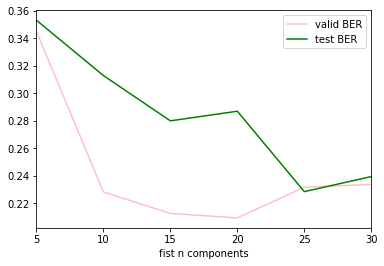

In [17]:
ax = plt.gca()
df.plot(kind='line',x='fist n components',y='valid BER', color='pink', ax=ax)
df.plot(kind='line',x='fist n components',y='test BER', color='green', ax=ax)
plt.show()

In [18]:
print('A model that uses just the first '+
      str(int(df[df['valid BER']==min(df['valid BER'])]['fist n components']))+
      ' components will be the best as it yields the lowest BER on the validation set.')

A model that uses just the first 20 components will be the best as it yields the lowest BER on the validation set.
